In [201]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from cnnlearning import *
from learningutils import *
from cell_no_cell import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

SHARED_CONES_2 = os.path.join(".", "data", "Cones2")
SHARED_CONES_3 = os.path.join(".", "data", "Cones3")
SHARED_VIDEOS_PATH = os.path.join(".", "data", "Shared_Videos")
OUTPUT_FOLDER = os.path.join(".", "data", "output")
TRAINED_MODEL_FOLDER = os.path.join(OUTPUT_FOLDER, "trained_models")

video_filenames = [file for file in [f for f in os.listdir(SHARED_VIDEOS_PATH) if f.endswith('avi') and 'OA790nm' in f]]
marked_video_filenames = [os.path.join(SHARED_VIDEOS_PATH, file) for file in video_filenames if 'marked' in file]
raw_video_filenames    = [os.path.join(SHARED_VIDEOS_PATH, file) for file in video_filenames if 'marked' not in file]

csv_filenames = [os.path.join(SHARED_VIDEOS_PATH, file) for file in [f for f in os.listdir(SHARED_VIDEOS_PATH) if f.endswith('csv') and 'OA790nm' in f]]

print("BLOOD CELLS")
print("-----------")
print("RAW VIDEOS:")
print(*marked_video_filenames, sep="\n")
print()

print("MARKED VIDEOS:")
print(*raw_video_filenames, sep="\n")
print()

print("CSV FILES:")
print(*csv_filenames, sep="\n")


print()
print("Cones2")
print("-----")
print("TIFF:")

cone_images_filenames = []
cone_csv_filenames = []

# cone_images_filenames_2 = [os.path.join(SHARED_CONES_2, file) for file in [f for f in os.listdir(SHARED_CONES_2) if f.endswith('tif')]]
# cone_csv_filenames_2 =  [os.path.join(SHARED_CONES_2, file)for file in [f for f in os.listdir(SHARED_CONES_2) if f.endswith('txt')]]
# cone_images_filenames.extend(cone_images_filenames_2)
# cone_csv_filenames.extend(cone_csv_filenames_2)

cone_images_filenames_3 = [os.path.join(SHARED_CONES_3, file) for file in [f for f in os.listdir(SHARED_CONES_3) if f.endswith('tif')]]
cone_csv_filenames_3 =  [os.path.join(SHARED_CONES_3, file)for file in [f for f in os.listdir(SHARED_CONES_3) if f.endswith('csv')]]

cone_images_filenames.extend(cone_images_filenames_3)
cone_csv_filenames.extend(cone_csv_filenames_3)

print(*cone_images_filenames, sep="\n")
print()

print("CSV:")
print(*cone_csv_filenames, sep="\n")

assert len(cone_images_filenames) == len(cone_csv_filenames)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda

BLOOD CELLS
-----------
RAW VIDEOS:
.\data\Shared_Videos\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm_marked.avi
.\data\Shared_Videos\Subject50_Session385_OD_(0,-1)_1.04x1.04_3247_OA790nm_marked.avi

MARKED VIDEOS:
.\data\Shared_Videos\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm_dewarped.avi
.\data\Shared_Videos\Subject50_Session385_OD_(0,-1)_1.04x1.04_3247_OA790nm.avi

CSV FILES:
.\data\Shared_Videos\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm_marked.csv
.\data\Shared_Videos\Subject50_Session385_OD_(0,-1)_1.04x1.04_3247_OA790nm_marked.csv

Cones2
-----
TIFF:
.\data\Cones3\AD_10252_790nm_OS__split_det__0032_ref_69_lps_20_lbss_10_sr_n_50_cropped_5_1.14e+03um N76.6um S.tif
.\data\Cones3\AD_10252_790nm_OS__split_det__0036_ref_94_lps_20_lbss_10_sr_n_50_cropped_5_1.47e+03um N20um S.tif
.\data\Cones3\AD_10252_790nm_OS__split_det__0044_ref_5_lps_20_lbss_10_sr_n_50_cropped_5_1.76e+03um

In [99]:
from scipy.spatial import Voronoi, voronoi_plot_2d
 
def get_random_points_in_voronoi_diagram(centroids, padding_size=(0, 0)):
    vor = Voronoi(centroids, qhull_options='Qbb Qc Qx', incremental=False)
    vor.close()

    edges = np.array(vor.ridge_vertices)

    edges_start = edges[:, 0]
    edges_end = edges[:, 1]

    vertices_start = vor.vertices[edges_start]
    vertices_end = vor.vertices[edges_end]

    t =  np.random.rand(vertices_start.shape[0])
   
    random_vertices = t[:, np.newaxis] * vertices_start + (1 - t[:, np.newaxis]) * vertices_end
    random_vertices = random_vertices[edges_start != -1]

    random_vertices = random_vertices[random_vertices[:, 0] >= 0]
    random_vertices = random_vertices[random_vertices[:, 0] <= 140]
    random_vertices = random_vertices[random_vertices[:, 1] >= 0]
    random_vertices = random_vertices[random_vertices[:, 1] <= 140]
    
    return random_vertices

In [100]:
%%script echo skipping

cxs = np.random.randint(0, 400, size=(12))
cys = np.random.randint(0, 400, size=(12))

rect_height = 20
rect_width = 20

fig = plt.figure() 
ax = fig.add_subplot(111) 

xys = np.array([cxs - rect_height, cys - rect_width])
print('cxs', cxs)
print('cys', cys)

for cx, cy in zip(cxs, cys):
    ax.add_patch(matplotlib.patches.Rectangle((cx - rect_width/2, cy - rect_height/2), rect_width, rect_height))
    # ax.add_patch(matplotlib.patches.Rectangle((2, 3), rect_width, rect_height))

rxs, rys = get_random_point_on_rectangle(cxs, cys, (rect_height, rect_width))
ax.scatter(cxs, cys, c='#ff7f0e', zorder=10)
ax.scatter(rxs, rys, c='#777f0e', zorder=10)

plt.xlim([cxs.min() - rect_width / 2,  cxs.max() + rect_width / 2 ]) 
plt.ylim([cys.min() - rect_height / 2, cys.max() + rect_height /2 ]) 
pass

Couldn't find program: 'echo'


In [101]:
# Input 
padding = 'valid'
cone_image_size =(33, 33)

# Extract cone and non-cone patches
cones = np.zeros([0, cone_image_size[0], cone_image_size[1]], dtype=np.float32)
non_cones = np.zeros([0, cone_image_size[0], cone_image_size[1]], dtype=np.float32)

for image_filename, csv_filename in zip(cone_images_filenames, cone_csv_filenames):
    image = plt.imread(image_filename)
    positions = np.genfromtxt(csv_filename, delimiter=',')
    # positions = positions[:, [0, 1]]
    cone_patches = extract_patches_at_positions(image, 
                           positions,
                           patch_size=cone_image_size,
                           visualize_patches=False,
                           padding=padding).astype(np.float32) / 255
    
    non_cone_patches = extract_patches_at_positions(image,
                                                    get_random_points_in_voronoi_diagram(positions),
                                                    patch_size=cone_image_size,
                                                    visualize_patches=False,
                                                    padding=padding).astype(np.float32) / 255
    
    cones = np.append(cones, cone_patches, axis=0)
    non_cones = np.append(non_cones, non_cone_patches, axis=0)
    
# cones = np.rot90(cones, 2, axes=(1, 2))
# non_cones = np.rot90(non_cones, 2, axes=(1, 2))

# Print information
print("Cones are of type ", cones.dtype)
print("Image values are normalised beteween 0 and 1 by dividing by 255.")
print("Cones (min, max)", (cones.min(), cones. max()))
print("Non cones (min, max)", (non_cones.min(), non_cones.max()))

print("Cones shape", cones.shape)
print("Cones dtype", cones.dtype)
print("Non cones shape", non_cones.shape)
print("Non cones dtype", non_cones.dtype)

Cones are of type  float32
Image values are normalised beteween 0 and 1 by dividing by 255.
Cones (min, max) (0.0, 1.0)
Non cones (min, max) (0.0, 1.0)
Cones shape (28657, 33, 33)
Cones dtype float32
Non cones shape (40601, 33, 33)
Non cones dtype float32


Cones shape (28657, 33, 33)
Cones dtype float32
Non cones shape (40601, 33, 33)
Non cones dtype float32


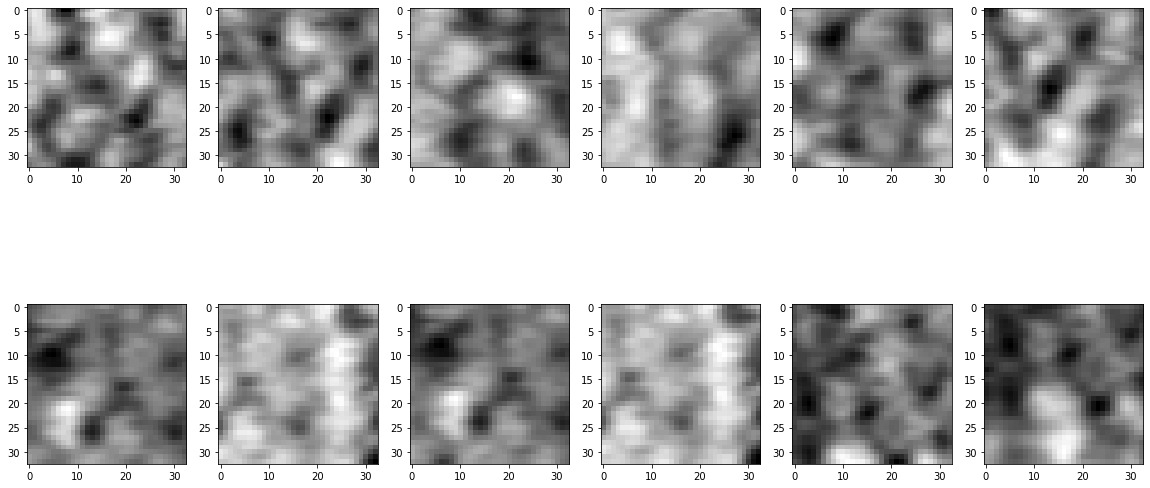

In [102]:
fig, axes = plt.subplots(2, 6, figsize=(20, 10))
axes[0, 0].imshow(cones[0], cmap='gray')
axes[0, 1].imshow(cones[1], cmap='gray')
axes[0, 2].imshow(cones[2], cmap='gray')
axes[0, 3].imshow(cones[3], cmap='gray')
axes[0, 4].imshow(cones[4], cmap='gray')
axes[0, 5].imshow(cones[5], cmap='gray')

axes[1, 0].imshow(non_cones[0], cmap='gray')
axes[1, 1].imshow(non_cones[1], cmap='gray')
axes[1, 2].imshow(non_cones[2], cmap='gray')
axes[1, 3].imshow(non_cones[3], cmap='gray')
axes[1, 4].imshow(non_cones[4], cmap='gray')
axes[1, 5].imshow(non_cones[5], cmap='gray')

print("Cones shape", cones.shape)
print("Cones dtype", cones.dtype)
print("Non cones shape", non_cones.shape)
print("Non cones dtype", non_cones.dtype)

# Train Model
[Click Here to load model instead](#load_model)


In [6]:
%%script echo skipping
# SKIPPING THIS CELL, REMOVE TO TRAIN

n_cones = cones.shape[0]
n_non_cones = non_cones.shape[0]

dataset = LabeledImageDataset(
        np.concatenate((cones[:n_cones, ...],            non_cones[:n_non_cones, ...]), axis=0),
        np.concatenate((np.ones(n_cones).astype(np.int), np.zeros(n_non_cones).astype(np.int)), axis=0)
    )

trainset_size = int(len(dataset) * 0.98)
validset_size = len(dataset) - trainset_size

trainset, validset = torch.utils.data.random_split(dataset, (trainset_size, validset_size))

model = CNN(convolutional=
            nn.Sequential(
                nn.Conv2d(1, 32, padding=2, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(kernel_size=(3, 3), stride=2),
                
                nn.Conv2d(32, 32, padding=2, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=3, padding=1, stride=2),
                
                nn.Conv2d(32, 64, padding=2, kernel_size=5),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=3, padding=1, stride=2),
            ),
            dense_input_dims=1024,
            dense=
            nn.Sequential(
                nn.Linear(1024, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(64),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.Linear(32, 2),
             #   nn.Softmax()
            )).to(device)

params = collections.OrderedDict(
    # lr = .001,
    #optimizer=torch.optim.SGD(model.parameters(), lr=.001, weight_decay=5e-5, momentum=0.9),
    # optimizer = torch.optim.Adam(model.parameters(), lr=.001, weight_decay=5e-4),
    optimizer = torch.optim.Adam(model.parameters(), lr=.0001, weight_decay=5e-4),
    batch_size=1024 * 3,
    do_early_stop=True,# Optional default True
    early_stop_patience=80,
    learning_rate_scheduler_patience=100,
    epochs=1000,
    shuffle=True,
    # valid_untrunsformed_normals = valid_untrunsformed_normals,
    trainset=trainset,
    validset=validset,
)

results = train(model, params, criterion=torch.nn.CrossEntropyLoss(), device=device)

Couldn't find program: 'echo'


### Save Model

In [7]:
%%script skipping_this_cell_remove_me_to_run
# SKIPPING THIS CELL, REMOVE TO TRAIN

filename = f"cone_classification_cones3_va_{results.best_valid_accuracy}_new"
results.save(filename)
print(f"Best validatioin accuracy achieved {results.best_valid_accuracy}")
print()
print(f"Saved model as {filename}")

Couldn't find program: 'skipping_this_cell_remove_me_to_run'


<a id="load_model"></a>
# Load Model

In [103]:
# Without padding
# file_to_load = 'cone_classification_va_0.9293646155130667_new.pt'
padding = 'valid'

# For images with reflect padding
file_to_load = 'cone_classification_cones3_va_0.9500362056480811_new.pt'
padding = cv2.BORDER_REFLECT

# Load saved model
print(f"Loading model '{file_to_load}' ...")
model = CNN(convolutional=
            nn.Sequential(
                nn.Conv2d(1, 32, padding=2, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(kernel_size=(3, 3), stride=2),
                
                nn.Conv2d(32, 32, padding=2, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=3, padding=1, stride=2),
                
                nn.Conv2d(32, 64, padding=2, kernel_size=5),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.AvgPool2d(kernel_size=3, padding=1, stride=2),
            ),
            dense_input_dims=1024,
            dense=
            nn.Sequential(
                nn.Linear(1024, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(64),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.Linear(32, 2),
             #   nn.Softmax()
            )).to(device)

model.load_state_dict(torch.load(file_to_load))
model = model.eval()
print("Model loaded")

Loading model 'cone_classification_cones3_va_0.9500362056480811_new.pt' ...
Model loaded


### Evaluate accuracy on patches

In [104]:
n_cones = cones.shape[0]
n_non_cones = non_cones.shape[0]

labaled_dataset = LabeledImageDataset(
        np.concatenate((cones[:n_cones, ...],            non_cones[:n_non_cones, ...]), axis=0),
        np.concatenate((np.ones(n_cones).astype(np.int), np.zeros(n_non_cones).astype(np.int)), axis=0)
    )
predictions, accuracy = classify_labeled_dataset(labaled_dataset, model)

print(f'Number of cones: {n_cones}, Number of non cones: {n_non_cones}. Total {n_cones + n_non_cones} samples.')
print(f'Accuracy on {len(labaled_dataset)} samples:', accuracy)

Number of cones: 28657, Number of non cones: 40601. Total 69258 samples.
Accuracy on 69258 samples: 0.9744867018972537


# Evaluate network on a sample image

image filename:
.\data\Cones3\AD_10252_790nm_OS__split_det__0032_ref_69_lps_20_lbss_10_sr_n_50_cropped_5_1.14e+03um N76.6um S.tif
csv filename:
.\data\Cones3\AD_10252_790nm_OS__split_det__0032_ref_69_lps_20_lbss_10_sr_n_50_cropped_5_1.14e+03um N76.6um S_coords.csv

image shape (185, 184)


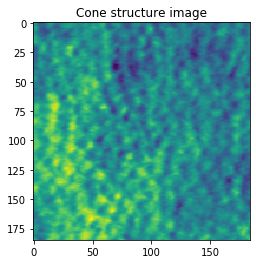

In [105]:
%matplotlib inline
%matplotlib inline

image_filename = cone_images_filenames[0]
csv_filename = cone_csv_filenames[0]

sample_image = plt.imread(cone_images_filenames[0]).astype(np.float32) / 255

print("image filename:", image_filename, "csv filename:", csv_filename, sep='\n')
print()
print("image shape", sample_image.shape)
plt.imshow(sample_image)
plt.title("Cone structure image")
pass


### Extract cone and non-cone patches from sample image

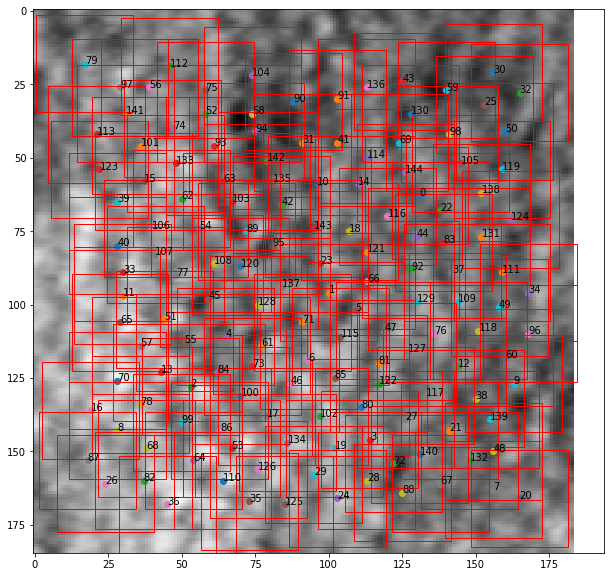

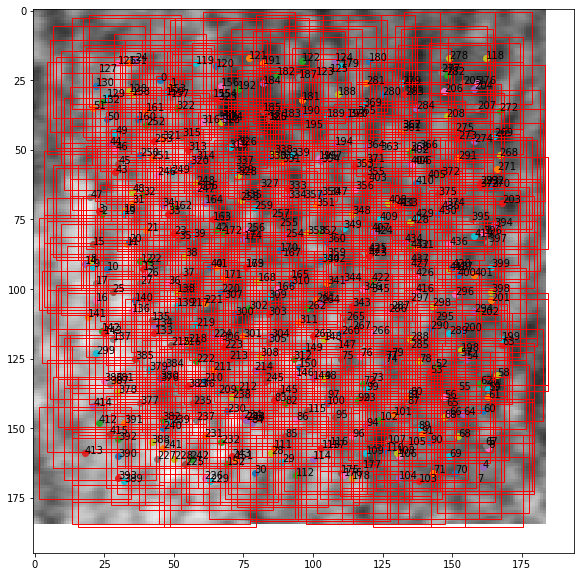

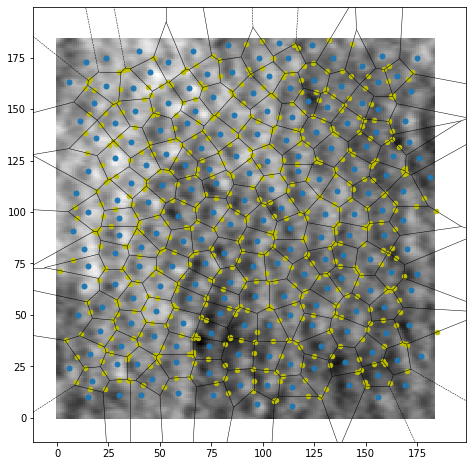

image filename
.\data\Cones3\AD_10252_790nm_OS__split_det__0032_ref_69_lps_20_lbss_10_sr_n_50_cropped_5_1.14e+03um N76.6um S.tif
csv filename
.\data\Cones3\AD_10252_790nm_OS__split_det__0032_ref_69_lps_20_lbss_10_sr_n_50_cropped_5_1.14e+03um N76.6um S_coords.csv
cone_patches (145, 33, 33)
non_cone_patches (438, 33, 33)


In [106]:
# Input
cone_image_size = (33, 33)
patch_height, patch_width = cone_image_size
padding = 'valid'

sample_image = plt.imread(image_filename)

# Get cone and non_cone positions
cone_positions = np.int32(np.genfromtxt(csv_filename, delimiter=',').round())
manual_cone_positions_orig = cone_positions.copy()

# Extract random positions from voronoi pattern
centroids = cone_positions
vor = Voronoi(centroids, qhull_options='Qbb Qc Qx', incremental=False)
vor.close()

edges = np.array(vor.ridge_vertices)

edges_start = edges[:, 0]
edges_end = edges[:, 1]

vertices_start = vor.vertices[edges_start]
vertices_end = vor.vertices[edges_end]

t = np.random.rand(vertices_start.shape[0])

random_vertices = t[:, np.newaxis] * vertices_start + (1 - t[:, np.newaxis]) * vertices_end
random_vertices = random_vertices[edges_start != -1]

random_vertices = random_vertices[random_vertices[:, 0] >= 0]
random_vertices = random_vertices[random_vertices[:, 0] <= sample_image.shape[0]]
random_vertices = random_vertices[random_vertices[:, 1] >= 0]
random_vertices = random_vertices[random_vertices[:, 1] <= sample_image.shape[1]]
non_cone_positions = random_vertices

cone_patches = extract_patches_at_positions(sample_image, 
                                            cone_positions,
                                            patch_size=cone_image_size,
                                            visualize_patches=True,
                                            padding=padding).astype(np.float32) / 255

non_cone_patches = extract_patches_at_positions(sample_image, 
                                                non_cone_positions,
                                                patch_size=cone_image_size,
                                                padding=padding,
                                                visualize_patches=True).astype(np.float32) / 255

fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax, line_width=0.5, point_size=10, show_vertices=False)
ax.scatter(random_vertices[:, 0], random_vertices[:, 1],  s=20, c='y')
ax.imshow(sample_image, cmap="gray")

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0] * 2, Size[1] * 2, forward=True) # Set forward to True to resize window along with plot in figure.
plt.show() 


print('image filename', image_filename, sep='\n')
print('csv filename', csv_filename, sep='\n')

print("cone_patches", cone_patches.shape)
print("non_cone_patches", non_cone_patches.shape)

pass

In [115]:
%%script skipping_this_cell_remove_me_to_run
# SKIPPING THIS CELL

%matplotlib notebook
%matplotlib notebook

# %matplotlib inline

import matplotlib.animation
sample_idx = 82
sample_image = plt.imread(cone_images_filenames[sample_idx])
positions = random_vertices

fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image, cmap='gray')
voronoi_plot_2d(vor, ax=ax[0], line_width=0.5, point_size=10, show_vertices=False)

fig = plt.gcf()
size = fig.get_size_inches()
fig.set_size_inches(size * 2)
import time

def update(i):
#     fig.suptitle(f'This is a somewhat long figure title {i}', fontsize=16)
    pos = positions[i]
    ax[0].scatter(pos[0], pos[1])
    patch = get_patch(sample_image, pos[0], pos[1], patch_size=(33, 33))
    if patch.shape == (33,33):
        ax[1].imshow(patch,  cmap='gray')
    else:
        ax[1].imshow(np.zeros([33, 33]),  cmap='gray')
    
ani = matplotlib.animation.FuncAnimation(fig, 
                                         update,
                                         frames=np.arange(1, len(positions)-1),
                                         interval=1000, repeat=False)
# plt.show()
# update(0)

Couldn't find program: 'skipping_this_cell_remove_me_to_run'


In [116]:
%%script skipping_this_cell_remove_me_to_run
# SKIPPING THIS CELL

%matplotlib notebook
%matplotlib notebook

# %matplotlib inline

import matplotlib.animation
sample_idx = 82
sample_image = plt.imread(cone_images_filenames[sample_idx])
positions = np.genfromtxt(cone_csv_filenames[sample_idx], delimiter=',')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image, cmap='gray')
fig = plt.gcf()
size = fig.get_size_inches()
fig.set_size_inches(size * 1)
import time

def update(i):
#     fig.suptitle(f'This is a somewhat long figure title {i}', fontsize=16)
    pos = positions[i]
    ax[0].scatter(pos[0], pos[1])
    patch = get_patch(sample_image, pos[0], pos[1], patch_size=(33, 33))
    if patch.shape == (33,33):
        ax[1].imshow(patch,  cmap='gray')
    else:
        ax[1].imshow(np.zeros([33, 33]),  cmap='gray')
    
ani = matplotlib.animation.FuncAnimation(fig, 
                                         update,
                                         frames=np.arange(1, len(positions)-1),
                                         interval=1000, repeat=False)
# plt.show()
# update(0)

Couldn't find program: 'skipping_this_cell_remove_me_to_run'


### Evaluate model on extracted patches

Sample image extracted cones shape:	 (145, 33, 33)
Sample image extracted cones dtype:	 float32
Sample image extracted non cones shape:	 (438, 33, 33)
Sample image extracted non cones dtype:	 float32
A total of 583 patches.
Model performance on the patches:
 (Positive accuracy , Negative accuracy) (0.9724137931034482, 0.9703196347031964)


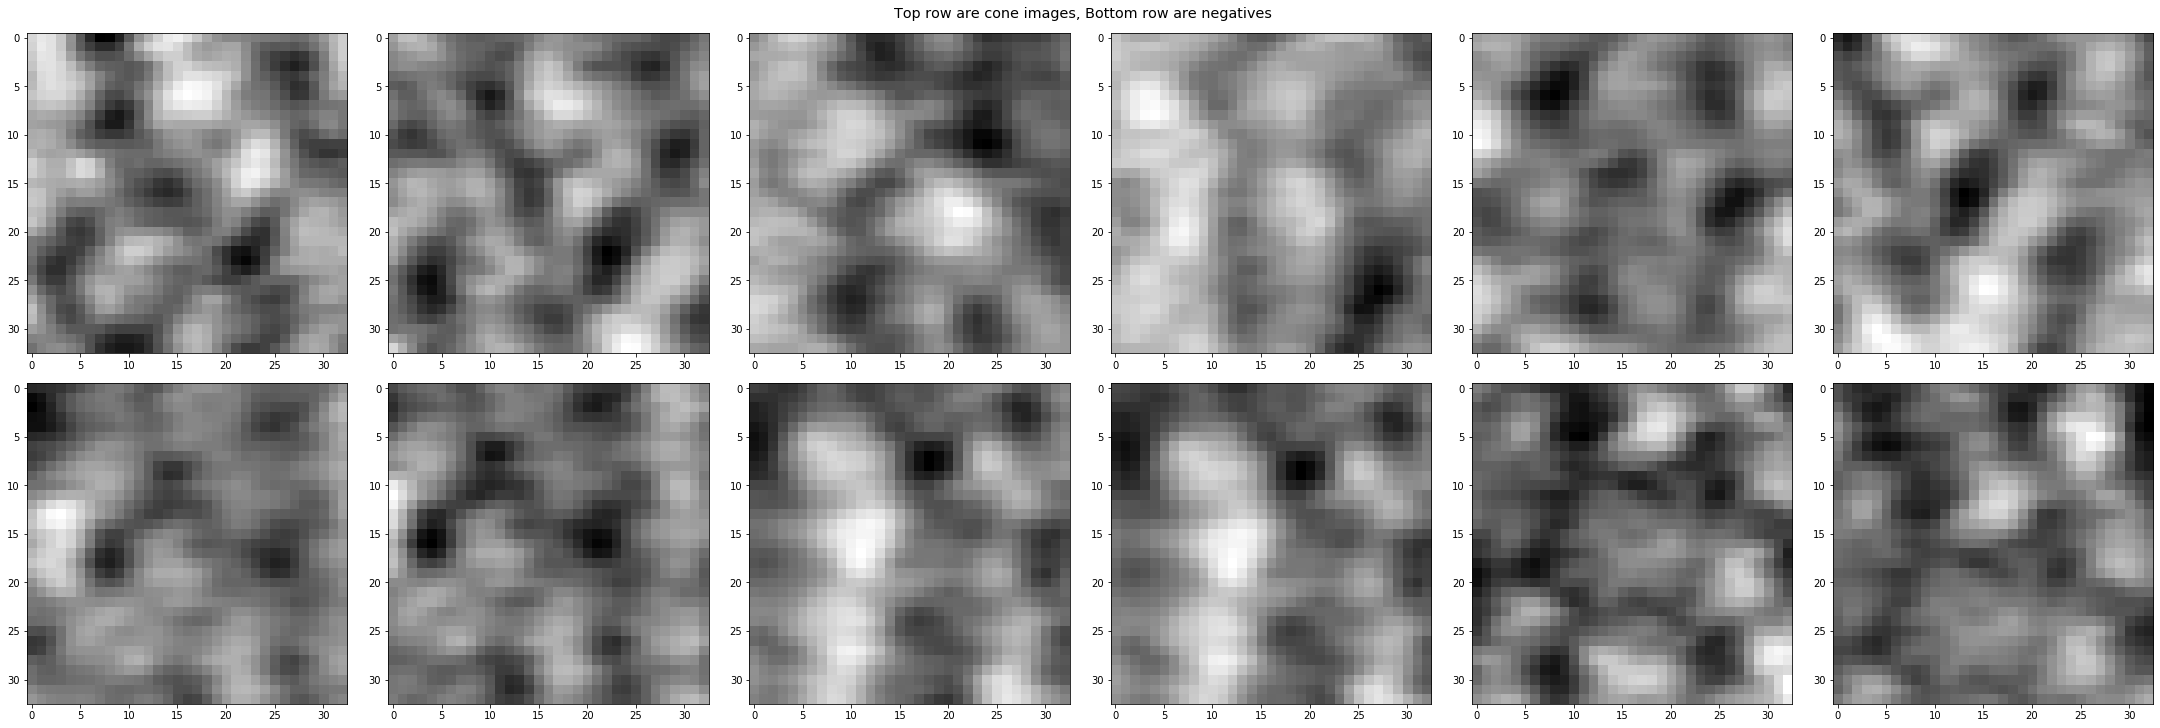

In [117]:
%matplotlib inline
%matplotlib inline

import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(2, 6, figsize=(30, 10), constrained_layout=True)

fig.suptitle("Top row are cone images, Bottom row are negatives", fontsize='x-large')

axes[0, 0].imshow(cone_patches[0], cmap='gray')
axes[0, 1].imshow(cone_patches[1], cmap='gray')
axes[0, 2].imshow(cone_patches[2], cmap='gray')
axes[0, 3].imshow(cone_patches[3], cmap='gray')
axes[0, 4].imshow(cone_patches[4], cmap='gray')
axes[0, 5].imshow(cone_patches[5], cmap='gray')

axes[1, 0].imshow(non_cone_patches[0], cmap='gray')
axes[1, 1].imshow(non_cone_patches[1], cmap='gray')
axes[1, 2].imshow(non_cone_patches[2], cmap='gray')
axes[1, 3].imshow(non_cone_patches[3], cmap='gray')
axes[1, 4].imshow(non_cone_patches[4], cmap='gray')
axes[1, 5].imshow(non_cone_patches[5], cmap='gray')

gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0, hspace=-10) # set the spacing between axes

print("Sample image extracted cones shape:\t", cone_patches.shape)
print("Sample image extracted cones dtype:\t", cone_patches.dtype)
print("Sample image extracted non cones shape:\t", non_cone_patches.shape)
print("Sample image extracted non cones dtype:\t", non_cone_patches.dtype)
print(f"A total of {len(cone_patches) + len(non_cone_patches)} patches.")

positive_accuracy = classify_images(cone_patches, model).sum().item() / len(cone_patches)
negative_accuracy = (((1 - classify_images(non_cone_patches, model)).sum().item()) / len(non_cone_patches))
print(f"Model performance on the patches:\n",
      f"(Positive accuracy , Negative accuracy) {(positive_accuracy, negative_accuracy)}")

### Generate probability map

Creating probability map...
Done


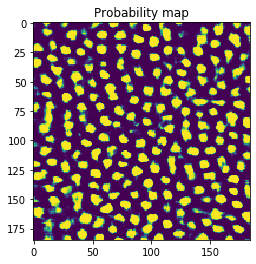

In [202]:
print('Creating probability map...')
# Also test the function
probability_map = get_frame_probability_map(sample_image,
                                            model, device='cuda',
                                            patch_size=cone_image_size)
plt.imshow(probability_map)
plt.title('Probability map')
print('Done')

### Demonstration how to get probability on probability map
Notice that we index probability (y, x)


In [203]:
x, y = np.int32(cone_positions[10, :])
cone_patch_index = np.ravel_multi_index([[y], [x]], dims=sample_image.shape[:2]).item()
patch = patches[cone_patch_index, ...]
    
print("Prediction", predict_single_patch(patch, model))
print('Probability map', probability_map[y, x])
print('Probability func', probability_map_func[y, x])

torch.Size([1, 1, 33, 33])
Prediction 0.9998012185096741
Probability map 0.9998012
Probability func 0.9998012


In [204]:
%%script skipping_this_cell

%matplotlib notebook
%matplotlib notebook

# %matplotlib inline

import matplotlib.animation
sample_idx = 82
sample_image = plt.imread(cone_images_filenames[sample_idx])
positions = np.int32(np.genfromtxt(cone_csv_filenames[sample_idx], delimiter=','))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_image, cmap='gray')
ax[1].imshow(probability_map)
fig = plt.gcf()
size = fig.get_size_inches()
fig.set_size_inches(size * 1)
import time

def update(i):
#     fig.suptitle(f'This is a somewhat long figure title {i}', fontsize=16)
    pos = positions[i]
    ax[0].scatter(pos[0], pos[1])
    patch = get_patch(sample_image, pos[0], pos[1], patch_size=(33, 33))
    
    ax[1].scatter(pos[0], pos[1])
    ax[1].set_title(f'{probability_map[pos[1], pos[0]]}')
    
ani = matplotlib.animation.FuncAnimation(fig, 
                                         update,
                                         frames=np.arange(1, len(positions)-1),
                                         interval=1000, repeat=False)
# plt.show()
# update(0)

Couldn't find program: 'skipping_this_cell'


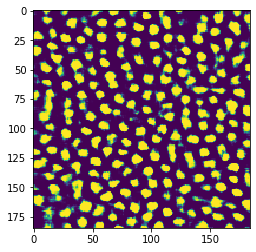

In [205]:
plt.imshow(probability_map)

207


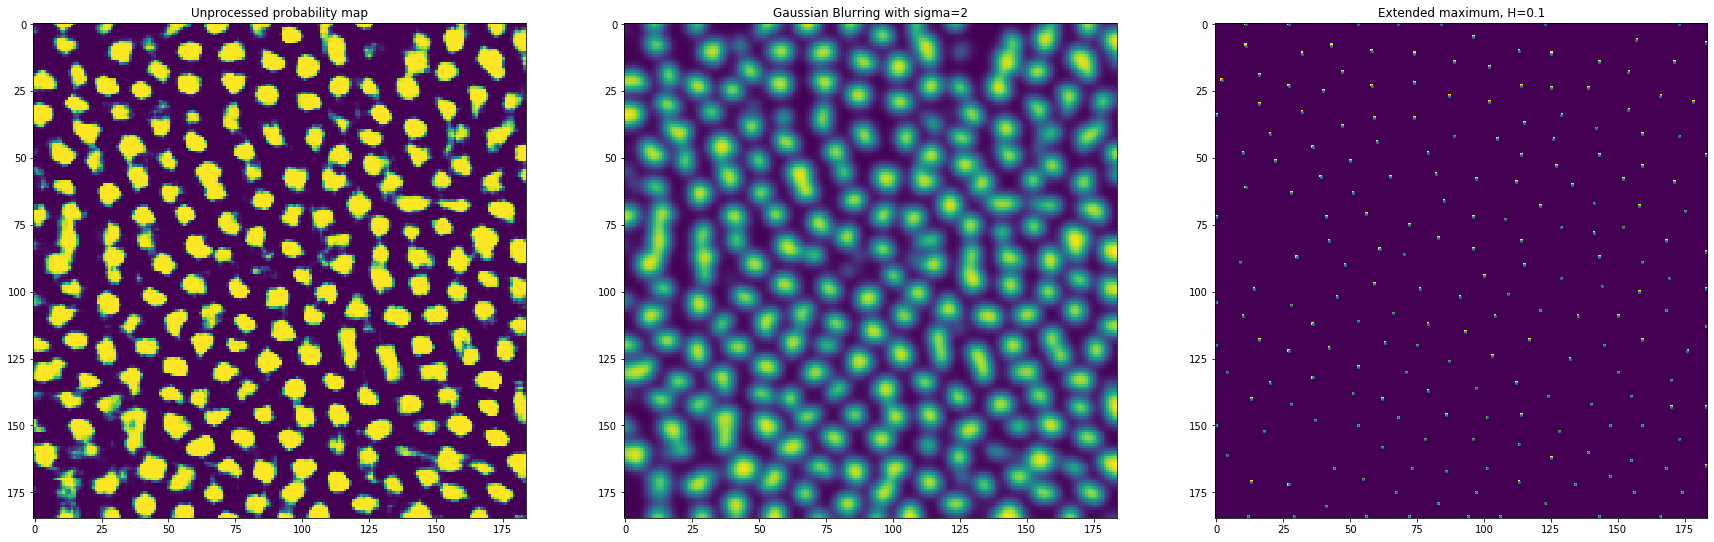

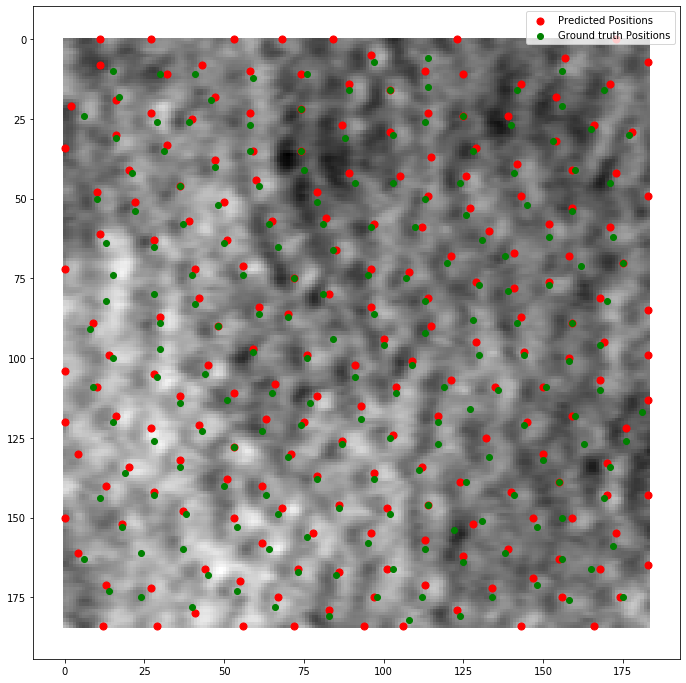

In [213]:
import mahotas as mh
from skimage import measure
from skimage import filters
from PIL import Image


gauss_sigma = 2
extended_maxima_H = 0.1

predicted_cell_positions_orig = get_cell_positions_from_probability_map(
    probability_map,
    gauss_sigma,
    extended_maxima_H,
    visualise_intermediate_results=True
)
ground_truth_positions_orig = ground_truth_positions.copy()

fig = plt.figure()
fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 3,
                     fig_size[1] * 3))

plt.imshow(sample_image, cmap='gray')
plt.scatter(predicted_cell_positions_orig[:, 0], predicted_cell_positions_orig[:, 1], c='r', s=50, label='Predicted Positions')
plt.scatter(ground_truth_positions_orig[:, 0], ground_truth_positions_orig[:, 1], c='g', label='Ground truth Positions')
plt.legend()
pass

In [214]:
predicted_cell_positions_orig[0]

array([11.,  0.])

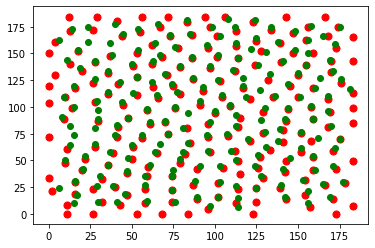

In [215]:
plt.scatter(predicted_cell_positions_orig[:, 0], predicted_cell_positions_orig[:, 1], c='r', s=50, label='Predicted Positions')
plt.scatter(ground_truth_positions_orig[:, 0], ground_truth_positions_orig[:, 1], c='g', label='Grounded Positions')


### Evaluate (Calculate Dice's coefficient)

In [216]:
gauss_sigmas = np.arange(1, 2, 0.2)
extended_maxima_Hs = np.arange(0.05, 0.4, 0.025)
extended_maxima_Hs

array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 ,
       0.275, 0.3  , 0.325, 0.35 , 0.375])

In [ ]:
np.

In [264]:
dices_coefficients = []
gauss_sigmas = np.arange(1, 9, 0.2)
extended_maxima_Hs = np.arange(0.05, 0.9, 0.025)

max_dices_coeff = 0
best_sigma = gauss_sigmas[0]
best_H = extended_maxima_Hs[0]
for s in gauss_sigmas:
    for h in extended_maxima_Hs:
        
        estimated_positions = get_cell_positions_from_probability_map(probability_map, 
                                                                      s, h)

        dices_coeff, _, _ = evaluate_results(ground_truth_positions_orig, 
                                             estimated_positions,
                                             sample_image,
                                             patch_size=(33, 33))
        
        if dices_coeff > max_dices_coeff:
            max_dices_coeff = dices_coeff
            best_sigma = s
            best_H = h
        dices_coefficients.append(dices_coeff)
dices_coefficients

[0.9507042253521126,
 0.950354609929078,
 0.950354609929078,
 0.9537366548042705,
 0.95,
 0.9424460431654677,
 0.9527272727272728,
 0.9527272727272728,
 0.948905109489051,
 0.948905109489051,
 0.9411764705882353,
 0.9411764705882353,
 0.9411764705882353,
 0.9411764705882353,
 0.9411764705882353,
 0.9372693726937269,
 0.929368029739777,
 0.9213483146067416,
 0.9213483146067416,
 0.9172932330827067,
 0.9049429657794676,
 0.9007633587786259,
 0.9007633587786259,
 0.896551724137931,
 0.8923076923076924,
 0.8923076923076924,
 0.8705882352941177,
 0.8616600790513834,
 0.8433734939759037,
 0.819672131147541,
 0.7949790794979079,
 0.7725321888412017,
 0.7510917030567685,
 0.7174887892376681,
 0.9540636042402827,
 0.9537366548042705,
 0.946236559139785,
 0.9530685920577617,
 0.9565217391304348,
 0.9527272727272728,
 0.9527272727272728,
 0.9527272727272728,
 0.945054945054945,
 0.9411764705882353,
 0.9411764705882353,
 0.9372693726937269,
 0.9372693726937269,
 0.9372693726937269,
 0.929368029739

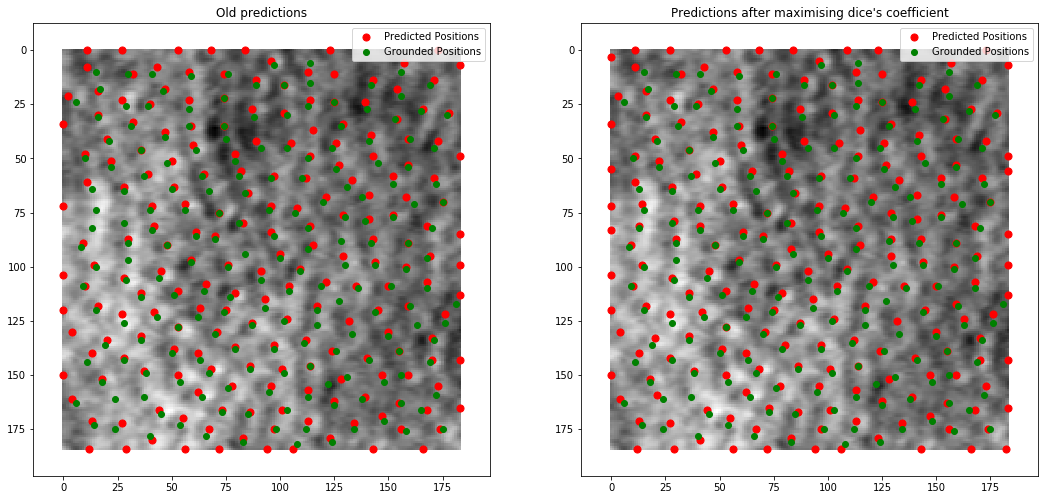

In [272]:
estimated_positions = get_cell_positions_from_probability_map(probability_map, best_sigma, best_H)

dices_coeff, _, _ = evaluate_results(ground_truth_positions_orig, 
                                     estimated_positions,
                                     sample_image,
                                     patch_size=(33, 33))

fig, axes = plt.subplots(1, 2)
axes[0].imshow(sample_image, cmap='gray')
axes[0].scatter(predicted_cell_positions_orig[:, 0], predicted_cell_positions_orig[:, 1], c='r', s=50, label='Predicted Positions')
axes[0].scatter(ground_truth_positions_orig[:, 0], ground_truth_positions_orig[:, 1], c='g', label='Grounded Positions')
axes[0].legend()
axes[0].set_title('Old predictions')

axes[1].imshow(sample_image, cmap='gray')
axes[1].scatter(estimated_positions[:, 0], estimated_positions[:, 1], c='r', s=50, label='Predicted Positions')
axes[1].scatter(ground_truth_positions_orig[:, 0], ground_truth_positions_orig[:, 1], c='g', label='Grounded Positions')
axes[1].legend()
axes[1].set_title("Predictions after maximising dice's coefficient")


fig_size = fig.get_size_inches()
fig.set_size_inches((fig_size[0] * 3,
                     fig_size[1] * 3))

## Test imextendemax implementation

In [ ]:
import mahotas as mh
from skimage import measure
from skimage import filters

# regionalmax test
A = 10 * np.ones([11,11])
A[2:4,2:4] = 22 
A[6:8,6:8] = 33
A[2,7] = 44
A[3,8] = 45
A[4,9] = 44

print("Grayscale Image")
print(A)

# structuring_element = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.bool) # 4 connectivity
structuring_element = np.ones([3, 3], dtype=np.bool) # 8 connectivity
print('Structuring element:')
print(structuring_element)

print('Regional Maxima result:')
BW = mh.regmax(A, Bc=structuring_element)
print(BW)

In [ ]:
# Filtering by region-size
print("Binary Image:")
print(BW)
labeled, nr_objects = mh.label(BW, Bc=structuring_element)
print('Labeled:')
print(labeled)

sizes = mh.labeled.labeled_size(labeled)
too_small = np.where(sizes <= 1)

print("Filtering regions that are too small, Notice that the region of 1 (the 2) is removed:")
labeled = mh.labeled.remove_regions(labeled, too_small)
print(labeled)

In [ ]:


A = 10 * np.ones([11,11])
A[2:4,2:4] = 22 
A[6:8,6:8] = 33
A[2,7] = 44
A[3,8] = 45
A[4,9] = 44

A /= 255
print("Grayscale Image")
print(A)

H = 0.17647059
print(f"Suppressing Maxima below and equal to H={H}")
A = extrema.h_maxima(A, H)
print(A)

In [ ]:
A = 10 * np.ones([11,11])
A[2:4,2:4] = 22 
A[6:8,6:8] = 33
A[2,7] = 44
A[3,8] = 45
A[4,9] = 44

print("Grayscale Image")
print(A)

print(imextendedmax(A, 22, conn=4))
plt.imshow(A)
# plt.imshow(imextendedmax(A, 22, conn=4))